# Load Data

In [10]:
using DataFrames: groupby, combine

bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")

########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)
store_bundle(tickers_df; bundle_id="NASDAQscreener_"*bundle_id, archive=true, cache_dir=cache_dir)
#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)
@info "Done!"
first(data,4)

[ Info: Storing /root/project/dissertationFigures/data/cache/Mark1/2023_08_19_16_9_49_915.parq.snappy
[ Info: Done!


Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,11.25,11.25,10.5,10.95,64140,2017-01-03T10:30:00,1483453800,NMS,America/New_York,USD,AMRS,NMS/AMRS
2,11.7,11.7,10.95,11.4,88980,2017-01-04T10:30:00,1483540200,NMS,America/New_York,USD,AMRS,NMS/AMRS
3,11.85,12.0,11.25,11.55,137260,2017-01-05T10:30:00,1483626600,NMS,America/New_York,USD,AMRS,NMS/AMRS
4,12.15,12.15,11.7,11.85,304647,2017-01-06T10:30:00,1483713000,NMS,America/New_York,USD,AMRS,NMS/AMRS


[ Info: Storing /root/project/dissertationFigures/data/cache/NASDAQscreener_Mark1/2023_08_19_17_16_37_731.parq.snappy


✏ Parquet2.FileWriter{IOStream}(/root/project/dissertationFigures/data/cache/NASDAQscreener_Mark1/2023_08_19_17_16_37_731.parq.snappy)

In [1]:
# If you already have the data somewhere accessible by the cache loading the data directly is faster
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
data=load_bundle(bundle_id;cache_dir=cache_dir)
using AirBorne.ETL.AssetValuation: stockValuation, returns
dollar_symbol = "FEX/USD"
account_currency = dollar_symbol
sv=stockValuation(data) # Stock Value dataframe
sv[!,dollar_symbol].=1.0 
sr=returns(sv) # Stock return dataframe
@info "DataGenerated"
# savefig(plotd,"file.png")

[ Info: DataGenerated


In [9]:
# unique(data[!,:symbol])

["SPR", "CNHI", "PACB", "AMRS", "TGI", "TSLA", "AMZN", "CCL", "AMSC", "JBLU", "NVDA", "AAPL", "NOK", "MSFT", "GOOGL", "AGNC", "MPW", "DEI", "HPP", "BRX", "WRK", "WSC", "AGI", "QSR", "IMO", "TTOO", "ARDX", "KDNY", "ESPR", "TDOC", "MET", "CG", "CFG", "ARCC", "ALLY", "ABEV", "SFM", "BG", "TWNK", "DAR", "KMI", "INFN", "TRGP", "CLNE", "CIEN", "PLUG", "DVN", "AR", "KOS", "WTI", "CSCO", "DISH", "EXTR", "TEF", "FFIV", "CCJ", "KGC", "RIO", "BVN", "EVA", "RUN", "ENR", "ULBI", "JYNT"]

# Forecast methods

In [7]:
using AirBorne.Structures: ContextTypeA,c_get
using AirBorne.ETL.AssetValuation: covariance
using Statistics: cov,mean
using JuMP: @variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using Ipopt: Ipopt
using HiddenMarkovModels: HMM, transition_matrix, baum_welch, viterbi, obs_distribution, rand_trans_mat #, em
using Distributions: MvNormal
using LinearAlgebra: I



##################
### Last Value ###
##################
function LV_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    varianceWindowSize  = c_get(context, "varianceWindowSize", 7)
    expectedReturnWindowSize  = c_get(context, "expectedReturnWindowSize", 7)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    
    minDataPoints =  max(expectedReturnWindowSize,varianceWindowSize)+1
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    # On an update this can be made more efficient by only calculating the latest value
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μ = mean(rMat[end-expectedReturnWindowSize+1:end,:];dims=1)
    if varianceWindowSize>1
        Σ = cov(rMat[end-varianceWindowSize+1:end,:])
    else
        Σ = zeros(size(rMat,2),size(rMat,2))
    end
    return [(μ,Σ) for i=1:futureHorizon] 
end

#########################
### Linear Regression ###
#########################
function LR_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    elementWise = c_get(context,"elementWise",true)
    varianceWindowSize  = c_get(context, "varianceWindowSize", 7)
    expectedReturnWindowSize  = c_get(context, "expectedReturnWindowSize", 7)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    
    minDataPoints =  pastHorizon+max(expectedReturnWindowSize,varianceWindowSize)
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μMat = zeros(futureHorizon,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)
    for i= size(rMat,1)-pastHorizon+1:size(rMat,1) 
        ix= i-(size(rMat,1)-pastHorizon) 
      μMat[ix,:] = mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1)
      ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:])
    end
    
    # Pre-allocate Forecast Matrices
    μFMat = zeros(futureHorizon,size(rMat,2))
    ΣFMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)

    if elementWise # Forecast each entry of μ & Σ using normal linear regression
        aμ= zeros(size(μMat[1,:]))
        bμ= zeros(size(μMat[1,:]))
        aΣ= zeros(size(ΣMat[:,:,1]))
        bΣ= zeros(size(ΣMat[:,:,1]))
        X = hcat(ones(pastHorizon,1), 1:pastHorizon)
        XX=((X'*X)^-1)
        for i=1:length(aμ)
            bμ[i],aμ[i] = XX * (X' * μMat[:,i])
            for j=1:i # Leverage Symmetry
               bΣ[j,i],aΣ[j,i] = bΣ[i,j],aΣ[i,j] =  XX * (X' * ΣMat[i,j,:])
            end
        end
    else # Forecast μ & Σ as points of a high dimensional space
        μmodel = Model(Ipopt.Optimizer)
        μShape=size(μMat[1,:])[1]
        @variable(μmodel, a[1:μShape[1]])
        @variable(μmodel, b[1:μShape[1]])
        @objective(μmodel,Min,sum([sum(x.^2) for x in [a*i+b-μMat[i,:] for i=1:pastHorizon]]))
        optimize!(μmodel)
        aμ = deepcopy(value.(a)) 
        bμ = deepcopy(value.(b)) 
        Σmodel = Model(Ipopt.Optimizer)
        ΣShape=size(ΣMat[:,:,1])
        @variable(Σmodel, a[1:ΣShape[1],1:ΣShape[2]]) 
        @variable(Σmodel, b[1:ΣShape[1],1:ΣShape[2]])# I could add constraint of symmetry & diagonal being strictly positive
        @objective(Σmodel,Min,sum([sum(x.^2) for x in [a*i+b-ΣMat[:,:,i] for i=1:pastHorizon]]))
        optimize!(Σmodel)
        aΣ = deepcopy(value.(a)) 
        bΣ = deepcopy(value.(b)) 
    end

    μf(i) = aμ.*i + bμ
    Σf(i) = aΣ.*i + bΣ
    out=[]
    for i = 1:futureHorizon
        μFMat[i,:] = μf(i+pastHorizon)'
        ΣFMat[:,:,i] = Σf(i+pastHorizon)
        push!(out,(μFMat[i,:],ΣFMat[:,:,i]))
    end
   return out 
end



###################
### Behavioural ###
###################

function quickBehaviouralForecast(Y,y_ini)
   return  Y[length(y_ini)+1:end,:] * (Y[1:length(y_ini),:]\y_ini)
end

function behaviouralForecast(context::ContextTypeA)
    
    ########################
    ### Hyper-Parameters ###
    ########################
    elementWise = c_get(context,"elementWise",true)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    varianceWindowSize  = get(context.parameters, "varianceWindowSize", 0)
    expectedReturnWindowSize  = get(context.parameters, "expectedReturnWindowSize", 1)
    
    # The minimum data points in case of elementwise forecast is equal to the past horizon (I may exclude the currency as its value is always 1, thus its returns and variance always 0)
    trajetory_length = (pastHorizon + futureHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    n_columns_for_reversibility = (pastHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    N = trajetory_length + n_columns_for_reversibility # Number of datapoints in Hankel Matrix
    
    minDataPoints =  trajetory_length + n_columns_for_reversibility +  max(expectedReturnWindowSize,varianceWindowSize) # @info "minDataPoints" minDataPoints
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end

    ###############################
    ### Statistics Calculations ###
    ###############################
    
    # TODO: Implement incremental updates to Hankel Matrix to improve efficiency
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix
    if c_get(context,"excludeCurrencyFromCalculation", true)
        rMat = rMat[:,1:end-1] # Remove last column
    end
    
    μMat = zeros(N,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),N)
    for i= size(rMat,1)-N+1:size(rMat,1) 
        # @info i
        ix= i-(size(rMat,1)-N) 
        # @info ix
      μMat[ix,:] = expectedReturnWindowSize > 1 ? mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1) : rMat[i,:]
      if  varianceWindowSize > 1; ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:]); end
    end
    
    ###############################
    ### Behavioural Forecasting ###
    ###############################
    
    # Memory pre-allocation
    μFMat = zeros(futureHorizon,size(rMat,2)+1) # Forecast of expected return
    ΣFMat = zeros(size(rMat,2)+1,size(rMat,2)+1,futureHorizon) # Forecast of variance
    if elementWise
        
        # Memory pre-allocation
        HΣi = zeros(trajetory_length,n_columns_for_reversibility) # Individual Covariance Hankel Matrix for asset pair
        Hμ = zeros(trajetory_length,n_columns_for_reversibility, size(rMat,2)) # Hankel Matrices for expected returns
        HΣ = Dict() # Hankel Matrices for covariance (since there is a lot of symmetry in this matrix, a hashmap is chosen as storage structure)
        
        μ_ini = μMat[end-pastHorizon+1:end,:] # Initial condition for expected returns
        Σ_ini = zeros(size(rMat,2),size(rMat,2),pastHorizon)
        
        for assetIx=1:size(rMat,2) # Iterate over each column (each asset)
            Hμ[:,:,assetIx]= cat([ μMat[end-i-trajetory_length+1:end-i] for i=1:n_columns_for_reversibility]...;dims=2)
            μFMat[:,assetIx]= quickBehaviouralForecast(Hμ[:,:,assetIx],μ_ini[:,assetIx])
            if varianceWindowSize>1 # Only go here if necessary
                for coAssetIx=1:assetIx # Build Hankel Matrix for Covariance
                    Σ_ini[assetIx,coAssetIx,:] = Σ_ini[coAssetIx,assetIx,:] = ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] 
                    HΣi[:,:] = cat([ ΣMat[assetIx, coAssetIx, end-i-trajetory_length+1:end-i]  for i=1:n_columns_for_reversibility]...;dims=2)
                    HΣ[(coAssetIx,assetIx)] = HΣ[(assetIx,coAssetIx)] = HΣi
                    ΣFMat[coAssetIx,assetIx,:] = ΣFMat[assetIx,coAssetIx,:] = quickBehaviouralForecast(HΣi,ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] )
                end
            end
         end
    else # Apply Behavioural forecast to all asset together, we need chunks 
        nAssets=size(rMat,2)
        μVec = reshape(μMat',1,:) # Restructured into: [a1,b1,c1,a2,b2,c2,...,aN,bN,cN] # Reshape μMat into 1D vector, easier to manipulate # @info "μMat" μMat μVec
        μ_ini = μVec[end-pastHorizon*nAssets+1:end]
        Hμ= cat(reverse([μVec[end-trajetory_length-nAssets*(i-1)+1:end-nAssets*(i-1)] for i=1:n_columns_for_reversibility])...;dims=2) # @info "Hμ" μ_ini Hμ 
        μF =  quickBehaviouralForecast(Hμ,μ_ini )
        μFMat[:,1:end-1] = vcat([μF[1+nAssets*(i-1):nAssets*i]' for i=1:futureHorizon]...)# @info "μF" μF μFMat
        
        
    end
    return [(μFMat[i,:],ΣFMat[:,:,i]) for i=1:futureHorizon]
end


###########################
### Hidden Markov Model ###
###########################

function random_gaussian_hmm(N,dims)
       state_probability = ones(N) / N  # initial distribution (of the states)
       state_transition_matrix = rand_trans_mat(N)  # transition matrix (of the states)
       state_Covariance = Matrix(I, dims, dims).*1.0
       dists = [MvNormal(rand(dims),  state_Covariance) for n in 1:N]  # observation distributions (of the states)
       return HMM(state_probability, state_transition_matrix, dists)
end

function fitHMM(hmm_init,obs_seq)
    hmm_est, logL_evolution = baum_welch(hmm_init, obs_seq; rtol=-Inf, check_loglikelihood_increasing=false)
   return hmm_est
end

function gen_hmm(obs_seq::Vector{Vector{Float64}}; nHiddenStates::Int64=2, hmm_init::Union{Nothing,HMM}=nothing)
       if isnothing(hmm_init)
           hmm_init=random_gaussian_hmm(nHiddenStates,length(obs_seq[1]))
       end
         @info "fitHMM"
       return fitHMM(hmm_init,obs_seq)
end

matrix2seq(obs_seq) = [obs_seq[i,:] for i=1:size(obs_seq,1)]
get_current_state(hmm,obs_seq) = viterbi(hmm, obs_seq)[end]


function hmmForecast(context::ContextTypeA)
    excludeCurrencyFromCalculation = c_get(context, "excludeCurrencyFromCalculation", true)
    futureHorizon = c_get(context,"futureHorizon",7)
    # If new data has come update observation sequence
    if  size(context.extra.returnHistory,1)>context.extra.lastScanIx
        # Remove Currency Symbol (as they are all 0)
        symbols =  excludeCurrencyFromCalculation ? context.extra.symbolOrder[1:end-1] : context.extra.symbolOrder
        new_obs_seq = matrix2seq(float.(Matrix(
                    context.extra.returnHistory[context.extra.lastScanIx:end,symbols]
        )))
        if length(context.extra.obs_seq)==0
            context.extra.obs_seq=Vector{Vector{Float64}}(new_obs_seq)
        else
            append!(context.extra.obs_seq,new_obs_seq)
        end
        context.extra.lastScanIx = size(context.extra.returnHistory,1)
    end  
    if  (mod(context.extra.lastScanIx, context.parameters.recalibrationPeriod)==0) || isnothing(context.extra.hmm)
        context.extra.hmm = gen_hmm(context.extra.obs_seq; hmm_init=context.extra.hmm)
    end
    hmm = context.extra.hmm; N=length(hmm);
    fitDists=[obs_distribution(hmm,i) for i=1:length(hmm)]
    μs= [f.μ for f=fitDists];    Σs=[f.Σ for f=fitDists]
    q0 = zeros(N);
    q0[get_current_state(hmm,context.extra.obs_seq)] = 1 # Probability of each state at t=0
    μ0 = sum(q0.*μs); Σ0 = sum([ q0[i].*Σs[i] for i=1:N])
    M=length(μ0)
    oM= length(context.extra.symbolOrder)
    
    # Pre-allocation of output
    forecast = [(zeros(oM),zeros(oM,oM)) for i=1:futureHorizon] 
    for i=1:futureHorizon
        q1 = transition_matrix(hmm)*q0
        μ1 = sum(q1.*μs)
        Σ1 = sum([ q1[i].*(Σs[i] + ((μs[i]-μ1)*(μs[i]-μ1)'))  for i=1:N]) 
        q0,μ0,Σ0=q1,μ1,Σ1
        forecast[i][1][1:M]=μ1
        forecast[i][2][1:M,1:M]=Σ1
    end
    return forecast
end


hmmForecast (generic function with 1 method)

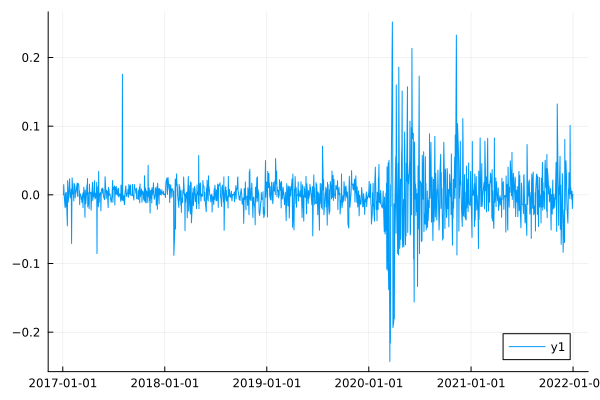

In [4]:
using Plots: plot
plot(sr[!,:date], sr[!,"NYQ/SPR"])